C:\Users\snehi\AppData\Local\Temp\ipykernel_9492\1295815228.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





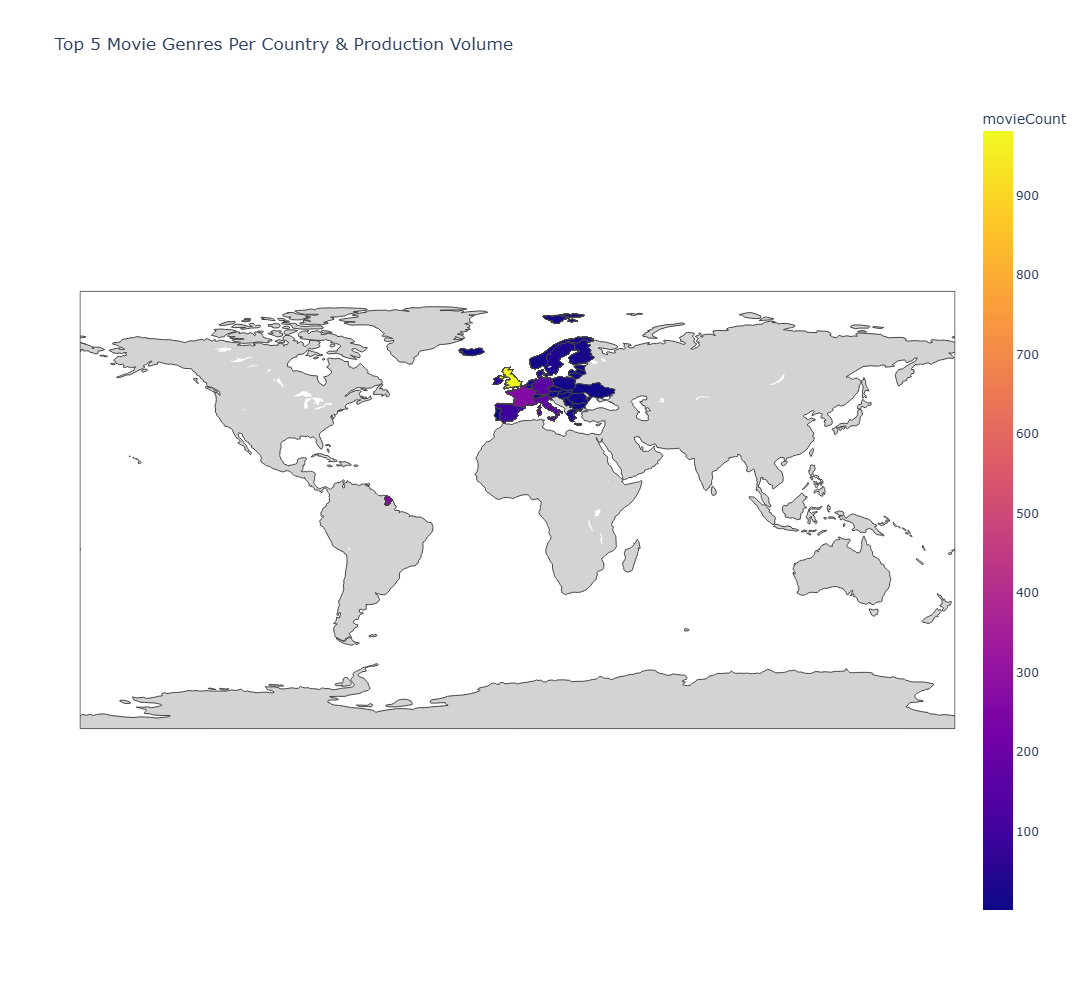

In [95]:
# Interpreting the World Map of Movie Genres & Production Volume
import plotly.express as px
import pandas as pd
import pycountry

# Load dataset
file_path = "European_data_2000.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Preprocess data
def preprocess_data(df, top_n=5):
    df["genres"] = df["genres"].astype(str).str.split(", ")  # Split genres
    exploded_df = df.explode("genres")  # Separate each genre
    
    country_genre_counts = exploded_df.groupby(["mainCountry", "genres"]).size().reset_index(name="count")
    top_genres = country_genre_counts.sort_values(["mainCountry", "count"], ascending=[True, False])
    top_genres = top_genres.groupby("mainCountry").head(top_n)
    
    # Map top genres per country
    top_genres_summary = top_genres.groupby("mainCountry")["genres"].apply(lambda x: ', '.join(map(str, x.unique()[:top_n]))).reset_index().rename(columns={"genres": "topGenres"})
    df = df.merge(top_genres_summary, on="mainCountry", how="left")
    df["topGenres"].fillna("No Data", inplace=True)
    
    # Manual corrections for misclassified regions
    country_corrections = {
        "French Guiana": "GUF",  # Corrected French Guiana
        "France": "FRA"
    }
    
    # Convert country names to ISO alpha-3 codes for mapping
    def get_country_code(name):
        if name in country_corrections:
            return country_corrections[name]
        try:
            return pycountry.countries.lookup(name).alpha_3
        except LookupError:
            return None  # Ignore unmatched countries
    
    df["iso_alpha"] = df["mainCountry"].apply(get_country_code)
    df.dropna(subset=["iso_alpha"], inplace=True)
    
    # Ensure French Guiana does not inherit France's data
    df.loc[df["mainCountry"] == "French Guiana", "iso_alpha"] = "GUF"
    
    # Count movies per country
    country_movie_counts = df["mainCountry"].value_counts().to_dict()
    df["movieCount"] = df["mainCountry"].map(country_movie_counts)
    
    return df

df = preprocess_data(df)

# Create interactive world map
fig = px.choropleth(
    df, locations="iso_alpha", locationmode="ISO-3",
    color="movieCount", hover_name="mainCountry",
    hover_data={"topGenres": True, "movieCount": True, "iso_alpha": False},
    title="Top 5 Movie Genres Per Country & Production Volume",
    color_continuous_scale="plasma"
)

fig.update_layout(
    geo=dict(showcoastlines=True, showland=True, landcolor="lightgray"),
    width=1000, height=1000
)

fig.show()


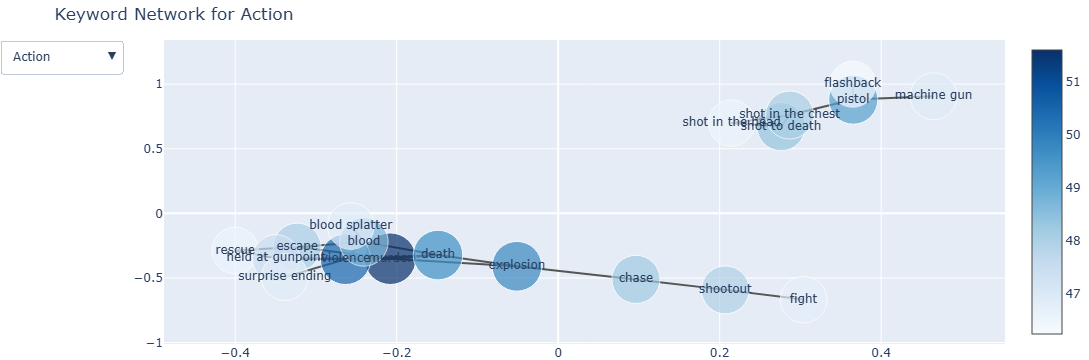

In [97]:
#An interactive network graph that shows the most frequently used keywords associated with different movie genres. 
#You can select a genre from a dropdown menu. Nodes (circles): Each keyword is represented as a circle.
#Edges (lines): If two keywords frequently appear together in movies of that genre, they are connected with a line.
#Size of Nodes: Bigger circles mean the keyword appears more often in that genre.
#Color Gradient: Darker colors indicate more frequent keywords. You can hover over nodes to see specific keywords.
#Insights: Understanding what themes are common in different genres. Identifying audience expectations based on frequently used themes. 
#This can help in exploring how different genres are connected through storytelling elements.

import plotly.graph_objects as go
import networkx as nx
from collections import Counter
import plotly.express as px
import numpy as np
import pandas as pd
import re

# Load dataset
file_path = "European_data_2000.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Ensure 'genres' and 'keywords' are strings
df["genres"] = df["genres"].fillna("").astype(str)
df["keywords"] = df["keywords"].fillna("").astype(str)

# Get available genres
genres_list = sorted(set(
    [genre for sublist in df["genres"].str.split(", ").tolist() for genre in sublist]
))

# Generate network graphs for all genres
fig = go.Figure()
visibility_flags = []

# Function to generate cleaned and visually improved network graph
def generate_network_data(selected_genre):
    filtered_df_genre = df[df["genres"].str.contains(re.escape(selected_genre), na=False)]
    all_keywords = filtered_df_genre["keywords"].str.split(", ").explode()
    
    # Get most common keywords (Top 20 for better connections)
    keyword_counts = Counter(all_keywords)
    top_keywords = [k for k, v in keyword_counts.most_common(20)]
    all_keywords = [k for k in all_keywords if k in top_keywords]
    
    # Create network graph with increased connections
    G = nx.Graph()
    keyword_pairs = list(zip(all_keywords[:-1], all_keywords[1:]))
    
    # Keep more connections (Top 30 co-occurring pairs)
    pair_counts = Counter(keyword_pairs)
    top_pairs = [pair for pair, count in pair_counts.most_common(30)]
    
    for pair in top_pairs:
        G.add_edge(pair[0], pair[1], weight=pair_counts[pair])
    
    # Adjust node spacing (bring nodes closer)
    pos = nx.spring_layout(G, seed=42, k=0.3)
    nodes = list(G.nodes)
    
    # Scale node sizes logarithmically to balance common/rare keywords
    node_size = [np.log1p(keyword_counts[node]) * 10 for node in nodes]
    
    # Create Plotly traces
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y, line=dict(width=2, color="#555"), hoverinfo="none", mode="lines", visible=False
    )
    
    node_x, node_y, node_text = [], [], []
    for node in nodes:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
    
    node_trace = go.Scatter(
        x=node_x, y=node_y, mode="markers+text", hoverinfo="text",
        marker=dict(
            size=node_size, 
            color=node_size, 
            colorscale="blues",  # Color gradient for better visibility
            showscale=True
        ),
        text=node_text, visible=False
    )
    
    return edge_trace, node_trace

# Add traces for all genres
for genre in genres_list:
    edge_trace, node_trace = generate_network_data(genre)
    fig.add_trace(edge_trace)
    fig.add_trace(node_trace)
    visibility_flags.append(False)

# Set first genre as visible
fig.data[0].visible = True
fig.data[1].visible = True

# Create dropdown menu
dropdown_buttons = []
for i, genre in enumerate(genres_list):
    visibility = [False] * len(fig.data)
    visibility[i * 2] = True  # Edge trace
    visibility[i * 2 + 1] = True  # Node trace
    
    dropdown_buttons.append(
        dict(label=genre, method="update", args=[{"visible": visibility}, {"title": f"Keyword Network for {genre}"}])
    )

fig.update_layout(
    title=f"Keyword Network for {genres_list[0]}",
    showlegend=False,
    hovermode="closest",
    margin=dict(b=0, l=0, r=0, t=40),
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            showactive=True
        )
    ]
)

fig.show()

In [99]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings

# OPTIONAL: suppress tokenizer warning
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.feature_extraction.text')

# --- Load and preprocess dataset ---
df = pd.read_csv("European_data_2000.csv")
df["release_year"] = pd.to_numeric(df["releaseYear"], errors="coerce")
df = df.dropna(subset=["release_year"])
df["release_year"] = df["release_year"].astype(int)
df["decade"] = (df["release_year"] // 10) * 10
df["keywords"] = df["keywords"].fillna("").astype(str)
df["genres"] = df["genres"].fillna("").astype(str)
df["imdbRating"] = pd.to_numeric(df["imdbRating"], errors="coerce")

# --- Build genre and decade lists ---
genres_list = sorted(set(g for sub in df["genres"].str.split(", ") for g in sub))
decades = sorted(df["decade"].unique())

# --- TF-IDF + PCA + KMeans clustering (optional: for grouping logic)
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(", "), lowercase=False)
tfidf_matrix = vectorizer.fit_transform(df["keywords"])
keywords = vectorizer.get_feature_names_out()

pca = PCA(n_components=10, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(tfidf_reduced)
keyword_cluster_map = dict(zip(keywords, kmeans.labels_))

# --- Function to plot keyword network ---
def draw_network(selected_genre, selected_decade):
    clear_output(wait=True)
    display(ui)

    if selected_genre is None:
        print("☝️ Please select a genre to generate the plot.")
        return

    filtered_df = df[
        (df["decade"] == selected_decade) &
        (df["genres"].str.contains(re.escape(selected_genre), na=False))
    ]

    if filtered_df.empty:
        print(f"⚠️ No data for genre '{selected_genre}' in {selected_decade}s.")
        return

    exploded = filtered_df[["keywords", "imdbRating"]].copy()
    exploded["keywords"] = exploded["keywords"].str.split(", ")
    exploded = exploded.explode("keywords").dropna()

    keyword_counts = Counter(exploded["keywords"])
    top_keywords = [k for k, v in keyword_counts.most_common(20)]
    filtered = exploded[exploded["keywords"].isin(top_keywords)]

    avg_ratings = filtered.groupby("keywords")["imdbRating"].mean().to_dict()
    keywords = filtered["keywords"].tolist()
    keyword_pairs = list(zip(keywords[:-1], keywords[1:]))
    pair_counts = Counter(keyword_pairs)
    top_pairs = [pair for pair, count in pair_counts.most_common(30)]

    G = nx.Graph()
    for pair in top_pairs:
        G.add_edge(pair[0], pair[1], weight=pair_counts[pair])

    if len(G.nodes) == 0:
        print(f"⚠️ Not enough keyword data to plot for '{selected_genre}' in {selected_decade}s.")
        return

    pos = nx.spring_layout(G, seed=42, k=0.3)
    node_sizes = [np.log1p(keyword_counts[n]) * 300 for n in G.nodes()]
    node_colors = [avg_ratings.get(n, 5.0) for n in G.nodes()]
    labels = {n: n for n in G.nodes()}

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap='RdYlGn')
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca(), label="Avg IMDb Rating")

    plt.title(f"Keyword Network – {selected_genre} ({selected_decade}s)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Widgets ---
genre_dropdown = widgets.Dropdown(
    options=[None] + genres_list,
    value=None,
    description='🎬 Genre:'
)

decade_slider = widgets.SelectionSlider(
    options=decades,
    value=decades[0],  # Safe default
    description='📅 Decade:'
)

ui = widgets.VBox([genre_dropdown, decade_slider])
out = widgets.interactive_output(draw_network, {
    'selected_genre': genre_dropdown,
    'selected_decade': decade_slider
})

# --- Display UI ---
display(ui, out)


Output()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

genre = widgets.Dropdown(options=['Drama', 'Comedy'], description='Genre:')
decade = widgets.IntSlider(min=1950, max=2020, value=2000, step=10, description='Decade:')
display(widgets.VBox([genre, decade]))


In [82]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager


(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
C:\Users\snehi\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:56: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
C:\Users\snehi\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:57: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
C:\Users\snehi\anaconda3\Lib\site-packages\jupyterlab\debuglog.py:58: UserWarning: See the log file for details: C:\Users\snehi\AppData\Local\Temp\jupyterlab-debug-_6mu4yry.log
  warnings.warn(f"See the 

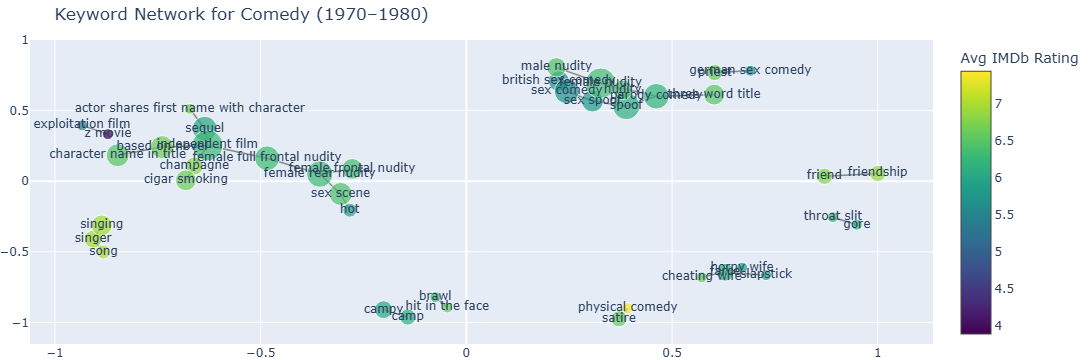

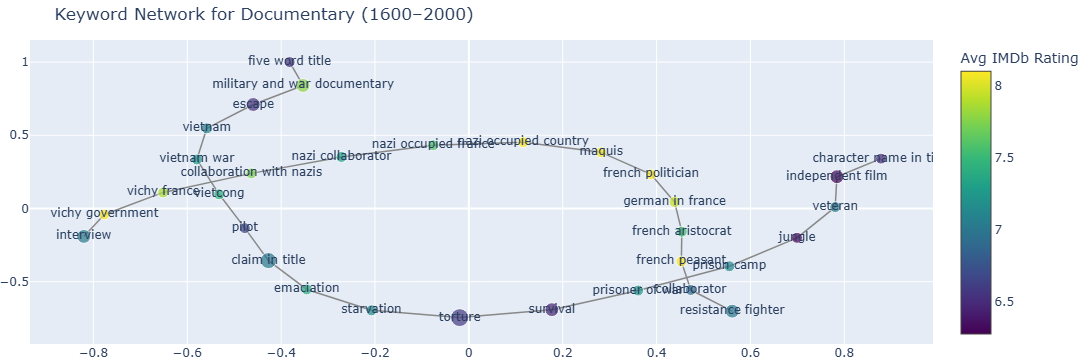

In [101]:
import plotly.graph_objects as go
import networkx as nx
from collections import Counter, defaultdict
import plotly.express as px
import numpy as np
import pandas as pd
import re
import tkinter as tk
from tkinter import ttk

# Load dataset
file_path = "European_data_2000.csv"
df = pd.read_csv(file_path)

# Ensure proper types
df["genres"] = df["genres"].fillna("").astype(str)
df["keywords"] = df["keywords"].fillna("").astype(str)
df["ReleaseYear"] = pd.to_numeric(df["releaseYear"], errors="coerce")
df["IMDBRating"] = pd.to_numeric(df["imdbRating"], errors="coerce")

genres_list = sorted(set([
    genre for sublist in df["genres"].str.split(", ").tolist() for genre in sublist
]))

# Compute keyword -> [ratings] mapping
keyword_ratings = defaultdict(list)
for _, row in df.iterrows():
    keywords = row["keywords"].split(", ")
    rating = row.get("IMDBRating", np.nan)
    for kw in keywords:
        if pd.notna(rating):
            keyword_ratings[kw].append(rating)

keyword_avg_rating = {kw: np.mean(ratings) for kw, ratings in keyword_ratings.items() if ratings}

# Main plotting function
def create_genre_plot(selected_genre, start_year, end_year):
    fig = go.Figure()
    filtered_df = df[
        df["genres"].str.contains(re.escape(selected_genre), na=False) &
        df["ReleaseYear"].between(start_year, end_year)
    ]
    all_keywords = filtered_df["keywords"].str.split(", ").explode()
    keyword_counts = Counter(all_keywords)

    # Lowered frequency threshold from 5 to 2
    top_keywords = [k for k, v in keyword_counts.items() if v >= 2 and k in keyword_avg_rating]
    all_keywords = [k for k in all_keywords if k in top_keywords]

    G = nx.Graph()
    keyword_pairs = list(zip(all_keywords[:-1], all_keywords[1:]))
    pair_counts = Counter(keyword_pairs)
    top_pairs = [pair for pair, count in pair_counts.most_common(30)]

    for pair in top_pairs:
        if pair[0] in top_keywords and pair[1] in top_keywords:
            G.add_edge(pair[0], pair[1], weight=pair_counts[pair])

    if not G.nodes:
        fig.update_layout(title="No data to display.")
        fig.show()
        return

    pos = nx.spring_layout(G, seed=42, k=0.3)
    nodes = list(G.nodes)

    node_size = [np.log1p(keyword_counts[node]) * 10 for node in nodes]
    node_color = [keyword_avg_rating.get(node, 0) for node in nodes]

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y, line=dict(width=1.5, color="#888"), hoverinfo="none", mode="lines"
    )

    node_x, node_y, node_text = [], [], []
    for node in nodes:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        freq = keyword_counts[node]
        rating = keyword_avg_rating.get(node, 0)
        node_text.append(f"{node}<br>Count: {freq}<br>Avg Rating: {rating:.2f}")

    node_trace = go.Scatter(
        x=node_x, y=node_y, mode="markers+text", hoverinfo="text",
        marker=dict(
            size=node_size,
            color=node_color,
            colorscale="viridis",
            colorbar=dict(title="Avg IMDb Rating"),
            showscale=True
        ),
        text=[node for node in nodes]
    )

    fig.add_trace(edge_trace)
    fig.add_trace(node_trace)
    fig.update_layout(
        title=f"Keyword Network for {selected_genre} ({start_year}–{end_year})",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40)
    )
    fig.show()

# Tkinter GUI for dropdown and year entry
def launch_gui():
    root = tk.Tk()
    root.title("Select Genre and Year Range")

    tk.Label(root, text="Select Genre:").grid(row=0, column=0)
    genre_var = tk.StringVar(root)
    genre_menu = ttk.Combobox(root, textvariable=genre_var, values=genres_list, state="readonly")
    genre_menu.grid(row=0, column=1)

    tk.Label(root, text="Start Year:").grid(row=1, column=0)
    start_entry = tk.Entry(root)
    start_entry.grid(row=1, column=1)

    tk.Label(root, text="End Year:").grid(row=2, column=0)
    end_entry = tk.Entry(root)
    end_entry.grid(row=2, column=1)

    def on_submit():
        selected_genre = genre_var.get()
        start_year = int(start_entry.get())
        end_year = int(end_entry.get())
        root.destroy()
        create_genre_plot(selected_genre, start_year, end_year)

    tk.Button(root, text="Plot", command=on_submit).grid(row=3, columnspan=2)
    root.mainloop()

if __name__ == "__main__":
    launch_gui()

In [105]:
pip install dash plotly pandas networkx


   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.9 MB 9.4 MB/s eta 0:00:01
   ----- ---------------------------------- 1.1/7.9 MB 13.8 MB/s eta 0:00:01
   -------- ------------------------------- 1.8/7.9 MB 14.2 MB/s eta 0:00:01
   ------------ --------------------------- 2.4/7.9 MB 13.8 MB/s eta 0:00:01
   --------------- ------------------------ 3.1/7.9 MB 14.1 MB/s eta 0:00:01
   ------------------ --------------------- 3.6/7.9 MB 13.6 MB/s eta 0:00:01
   --------------------- ------------------ 4.2/7.9 MB 13.4 MB/s eta 0:00:01
   ------------------------- -------------- 5.0/7.9 MB 13.9 MB/s eta 0:00:01
   ---------------------------- ----------- 5.7/7.9 MB 14.5 MB/s eta 0:00:01
   -------------------------------- ------- 6.5/7.9 MB 14.3 MB/s eta 0:00:01
   ------------------------------------ --- 7.2/7.9 MB 14.4 MB/s eta 0:00:01
   ---------------------------------------  7.9/7.9 MB 14.4 MB/s eta 0:00:01
   -----

In [1]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import networkx as nx
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import re

# Load dataset
file_path = "European_data_2000.csv"
df = pd.read_csv(file_path)

# Ensure proper types
df["genres"] = df["genres"].fillna("").astype(str)
df["keywords"] = df["keywords"].fillna("").astype(str)
df["ReleaseYear"] = pd.to_numeric(df["releaseYear"], errors="coerce")
df["IMDBRating"] = pd.to_numeric(df["imdbRating"], errors="coerce")

# Compute metadata
genres_list = sorted(set([
    genre for sublist in df["genres"].str.split(", ").tolist() for genre in sublist
]))

keyword_ratings = defaultdict(list)
for _, row in df.iterrows():
    keywords = row["keywords"].split(", ")
    rating = row.get("IMDBRating", np.nan)
    for kw in keywords:
        if pd.notna(rating):
            keyword_ratings[kw].append(rating)

keyword_avg_rating = {kw: np.mean(ratings) for kw, ratings in keyword_ratings.items() if ratings}

# Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("Keyword Network by Genre and Year Range"),
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': g, 'value': g} for g in genres_list],
        value=genres_list[0],
        placeholder="Select a genre"
    ),
    dcc.RangeSlider(
        id='year-slider',
        min=int(df["ReleaseYear"].min()),
        max=int(df["ReleaseYear"].max()),
        value=[int(df["ReleaseYear"].min()), int(df["ReleaseYear"].max())],
        marks={str(year): str(year) for year in range(int(df["ReleaseYear"].min()), int(df["ReleaseYear"].max()) + 1, 5)},
        step=1
    ),
    dcc.Graph(id='network-graph')
])

@app.callback(
    Output('network-graph', 'figure'),
    Input('genre-dropdown', 'value'),
    Input('year-slider', 'value')
)
def update_graph(selected_genre, year_range):
    start_year, end_year = year_range
    filtered_df = df[
        df["genres"].str.contains(re.escape(selected_genre), na=False) &
        df["ReleaseYear"].between(start_year, end_year)
    ]

    all_keywords = filtered_df["keywords"].str.split(", ").explode()
    keyword_counts = Counter(all_keywords)

    top_keywords = [k for k, v in keyword_counts.items() if v >= 2 and k in keyword_avg_rating]
    all_keywords = [k for k in all_keywords if k in top_keywords]

    G = nx.Graph()
    keyword_pairs = list(zip(all_keywords[:-1], all_keywords[1:]))
    pair_counts = Counter(keyword_pairs)
    top_pairs = [pair for pair, count in pair_counts.most_common(30)]

    for pair in top_pairs:
        if pair[0] in top_keywords and pair[1] in top_keywords:
            G.add_edge(pair[0], pair[1], weight=pair_counts[pair])

    fig = go.Figure()
    if not G.nodes:
        fig.update_layout(title="No data to display.")
        return fig

    pos = nx.spring_layout(G, seed=42, k=0.3)
    nodes = list(G.nodes)
    node_size = [np.log1p(keyword_counts[node]) * 10 for node in nodes]
    node_color = [keyword_avg_rating.get(node, 0) for node in nodes]

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y, line=dict(width=1.5, color="#888"), hoverinfo="none", mode="lines"
    )

    node_x, node_y, node_text = [], [], []
    for node in nodes:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        freq = keyword_counts[node]
        rating = keyword_avg_rating.get(node, 0)
        node_text.append(f"{node}<br>Count: {freq}<br>Avg Rating: {rating:.2f}")

    node_trace = go.Scatter(
        x=node_x, y=node_y, mode="markers+text", hoverinfo="text",
        marker=dict(
            size=node_size,
            color=node_color,
            colorscale="viridis",
            colorbar=dict(title="Avg IMDb Rating"),
            showscale=True
        ),
        text=[node for node in nodes]
    )

    fig.add_trace(edge_trace)
    fig.add_trace(node_trace)
    fig.update_layout(
        title=f"Keyword Network for {selected_genre} ({start_year}–{end_year})",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40)
    )
    return fig

if __name__ == '__main__':
    app.run(debug=True)


In [3]:
import dash
from dash import dcc, html, Input, Output, State, dash_table
import plotly.graph_objects as go
import networkx as nx
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import re

# Load dataset
file_path = "European_data_2000.csv"
df = pd.read_csv(file_path)

# Ensure proper types
df["genres"] = df["genres"].fillna("").astype(str)
df["keywords"] = df["keywords"].fillna("").astype(str)
df["ReleaseYear"] = pd.to_numeric(df["releaseYear"], errors="coerce")
df["IMDBRating"] = pd.to_numeric(df["imdbRating"], errors="coerce")

# Compute metadata
genres_list = sorted(set([
    genre for sublist in df["genres"].str.split(", ").tolist() for genre in sublist
]))

keyword_ratings = defaultdict(list)
for _, row in df.iterrows():
    keywords = row["keywords"].split(", ")
    rating = row.get("IMDBRating", np.nan)
    for kw in keywords:
        if pd.notna(rating):
            keyword_ratings[kw].append(rating)

keyword_avg_rating = {kw: np.mean(ratings) for kw, ratings in keyword_ratings.items() if ratings}

# Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H2("Keyword Network by Genre and Year Range"),
    dcc.Dropdown(
        id='genre-dropdown',
        options=[{'label': g, 'value': g} for g in genres_list],
        value=genres_list[0],
        placeholder="Select a genre"
    ),
    dcc.RangeSlider(
        id='year-slider',
        min=int(df["ReleaseYear"].min()),
        max=int(df["ReleaseYear"].max()),
        value=[int(df["ReleaseYear"].min()), int(df["ReleaseYear"].max())],
        marks={str(year): str(year) for year in range(int(df["ReleaseYear"].min()), int(df["ReleaseYear"].max()) + 1, 5)},
        step=1
    ),
    dcc.Graph(id='network-graph'),
    html.H4("Keyword Insight Table"),
    dash_table.DataTable(
        id='keyword-table',
        columns=[
            {"name": "Keyword", "id": "Keyword"},
            {"name": "Frequency", "id": "Frequency"},
            {"name": "Avg IMDb Rating", "id": "AvgRating"},
        ],
        style_table={"overflowX": "auto"},
        style_cell={"textAlign": "left"},
        style_data_conditional=[
            {
                'if': {'column_id': 'AvgRating'},
                'backgroundColor': '#e0f7fa',
            }
        ]
    )
])

@app.callback(
    [Output('network-graph', 'figure'), Output('keyword-table', 'data')],
    [Input('genre-dropdown', 'value'), Input('year-slider', 'value')]
)
def update_graph(selected_genre, year_range):
    start_year, end_year = year_range
    filtered_df = df[
        df["genres"].str.contains(re.escape(selected_genre), na=False) &
        df["ReleaseYear"].between(start_year, end_year)
    ]

    all_keywords = filtered_df["keywords"].str.split(", ").explode()
    keyword_counts = Counter(all_keywords)

    top_keywords = [k for k, v in keyword_counts.items() if v >= 2 and k in keyword_avg_rating]
    all_keywords = [k for k in all_keywords if k in top_keywords]

    G = nx.Graph()
    keyword_pairs = list(zip(all_keywords[:-1], all_keywords[1:]))
    pair_counts = Counter(keyword_pairs)
    top_pairs = [pair for pair, count in pair_counts.most_common(30)]

    for pair in top_pairs:
        if pair[0] in top_keywords and pair[1] in top_keywords:
            G.add_edge(pair[0], pair[1], weight=pair_counts[pair])

    fig = go.Figure()
    if not G.nodes:
        fig.update_layout(title="No data to display.")
        return fig, []

    pos = nx.spring_layout(G, seed=42, k=0.3)
    nodes = list(G.nodes)
    node_size = [np.log1p(keyword_counts[node]) * 10 for node in nodes]
    node_color = [keyword_avg_rating.get(node, 0) for node in nodes]

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y, line=dict(width=1.5, color="#888"), hoverinfo="none", mode="lines"
    )

    node_x, node_y, node_text = [], [], []
    for node in nodes:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        freq = keyword_counts[node]
        rating = keyword_avg_rating.get(node, 0)
        node_text.append(f"{node}<br>Count: {freq}<br>Avg Rating: {rating:.2f}")

    node_trace = go.Scatter(
        x=node_x, y=node_y, mode="markers+text", hoverinfo="text",
        marker=dict(
            size=node_size,
            color=node_color,
            colorscale="viridis",
            colorbar=dict(title="Avg IMDb Rating"),
            showscale=True
        ),
        text=[node for node in nodes]
    )

    fig.add_trace(edge_trace)
    fig.add_trace(node_trace)
    fig.update_layout(
        title=f"Keyword Network for {selected_genre} ({start_year}–{end_year})",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40)
    )

    keyword_table_data = [
        {"Keyword": node, "Frequency": keyword_counts[node], "AvgRating": round(keyword_avg_rating[node], 2)}
        for node in nodes
    ]
    keyword_table_data.sort(key=lambda x: (-x['Frequency'], -x['AvgRating']))

    return fig, keyword_table_data

if __name__ == '__main__':
    app.run(debug=True, port=8060)
